# Pre
I attempted to develop a good model with keras initially but evenutally I hit a roadblock and wasn't getting satisfactory predictions. I wanted to redevelop the model with all the new knowledge and insights. I have had Pytorch adviced to me and I figured I might as well have a go at it and get a feel for that as well.

# R: Preprocessing

In the directory "raw", there exists more images that there are pairs with masks. We realize that there is a difference between the images which names start with TXXXH and TXXXO. The TXXXH seemingly contain more noise than the TXXXO, so we could assume that those are preprocessed by denoising in some way.

We read all the files based on the existance of its accompanying masked equivalent.  
We evaluate whether the raw image is matched with the correct mask image.

We preprocess all the images and downsize them from 1400x1400 to 400x400, also convert the images to grayscale.

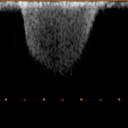

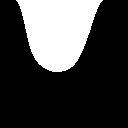

Number of samples: 153 153
raw/T001O_crop_0.png | mask/T001O_crop_0.png
raw/T001O_crop_1.png | mask/T001O_crop_1.png
raw/T002O_crop_2.png | mask/T002O_crop_2.png
raw/T002O_crop_3.png | mask/T002O_crop_3.png
raw/T002O_crop_4.png | mask/T002O_crop_4.png


In [7]:
import os, re
from PIL import Image
from IPython.display import Image as Img, display

img_size = 128, 128
input_pattern = re.compile("T[0-9]{3}O_crop_[0-9].png")
input_dir = "raw/"
target_pattern = re.compile("T[0-9]{3}OM_crop_[0-9].png")
target_dir = "mask/"

target_img_paths = sorted(
    [
        os.path.join(target_dir, fname.replace("OM", "O"))
        for fname in os.listdir(target_dir)
        if target_pattern.match(fname)
    ]
)
input_img_paths = []

for fname in target_img_paths:
  fname = fname.replace("mask/", "raw/")
  if os.path.isfile(fname):
    input_img_paths.append(fname)
  else:
    print("Bad input file: ", fname)

if not os.path.exists("target"):
    os.mkdir("target")
for infile in target_img_paths:
    outfile = infile.replace("mask/", "target/")
    if infile != outfile:
        try:
            im = Image.open(infile.replace("O", "OM"))
            # Downscale without smoothing/antialiasing with NEAREST alg
            # to get exactly either 0 or 255 pixel value
            im.thumbnail(img_size, Image.NEAREST)
            im.save(outfile, "PNG")
        except IOError:
            print("cannot create thumbnail for '%s'" % infile)

if not os.path.exists("input"):
    os.mkdir("input")
for infile in input_img_paths:
    outfile = infile.replace("raw/", "input/")
    if infile != outfile:
        try:
            im = Image.open(infile)
            
            # to grayscale
            # im = im.convert('L')

            im.thumbnail(img_size)
            im.save(outfile, "PNG")
        except IOError:
            print("cannot create thumbnail for '%s'" % infile)

# Show raw
display(Img(filename=target_img_paths[9].replace("mask/", "input/")))
# Show example of produced downscaled image
display(Img(filename=target_img_paths[9].replace("mask/", "target/")))

print("Number of samples:", len(input_img_paths), len(target_img_paths))

for input_path, target_path in zip(input_img_paths[:5], target_img_paths[:5]):
    print(input_path, "|", target_path)

# R: Preparing Pytorch and config

In [8]:
import torch
import os

# define the path to the images and masks dataset
IMAGE_DATASET_PATH = "input"
MASK_DATASET_PATH = "target"
# define the test split
TEST_SPLIT = 0.2
# determine the device to be used for training and evaluation
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# determine if we will be pinning memory during data loading
PIN_MEMORY = True if DEVICE == "cuda" else False

# define the number of channels in the input, number of classes,
# and number of levels in the U-Net model
NUM_CHANNELS = 1
NUM_CLASSES = 1
NUM_LEVELS = 3
# initialize learning rate, number of epochs to train for, and the
# batch size
INIT_LR = 0.001
# define the input image dimensions
INPUT_IMAGE_WIDTH = 128
INPUT_IMAGE_HEIGHT = 128
# define threshold to filter weak predictions
THRESHOLD = 0.4
# define the path to the base output directory
BASE_OUTPUT = "output"
# ensure directory
if not os.path.exists(BASE_OUTPUT):
    os.makedirs(BASE_OUTPUT)
# define the path to the output serialized model, model training
# plot, and testing image paths
MODEL_PATH = os.path.join(BASE_OUTPUT, "unet_tgs_salt.pth")
PLOT_PATH = os.path.sep.join([BASE_OUTPUT, "plot.png"])
TEST_PATHS = os.path.sep.join([BASE_OUTPUT, "test_paths.txt"])

# R: Segmentation dataset class

In [9]:
from torch.utils.data import Dataset
import cv2

class SegmentationDataset(Dataset):
	def __init__(self, imagePaths, maskPaths, transforms):
		# store the image and mask filepaths, and augmentation
		# transforms
		self.imagePaths = imagePaths
		self.maskPaths = maskPaths
		self.transforms = transforms
	def __len__(self):
		# return the number of total samples contained in the dataset
		return len(self.imagePaths)
	def __getitem__(self, idx):
		# grab the image path from the current index
		imagePath = self.imagePaths[idx]
		# load the image from disk, swap its channels from BGR to RGB,
		# and read the associated mask from disk in grayscale mode
		image = cv2.imread(imagePath)
		image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
		mask = cv2.imread(self.maskPaths[idx], 0)
		# check to see if we are applying any transformations
		if self.transforms is not None:
			# apply the transformations to both image and its mask
			image = self.transforms(image)
			mask = self.transforms(mask)
		# return a tuple of the image and its mask
		return (image, mask)

# R: Building the model for segmentation

The Neural Network is a U-Net network.
We create classes for the Decoder and Encoder blocksas well as a class for the overarching UNet network.

In [10]:
from torch.nn import ConvTranspose2d
from torch.nn import Conv2d
from torch.nn import MaxPool2d
from torch.nn import Module
from torch.nn import ModuleList
from torch.nn import ReLU
from torchvision.transforms import CenterCrop
from torch.nn import functional as F
import torch

class Block(Module):
	def __init__(self, inChannels, outChannels):
		super().__init__()
		# store the convolution and RELU layers
		self.conv1 = Conv2d(inChannels, outChannels, 3)
		self.relu = ReLU()
		self.conv2 = Conv2d(outChannels, outChannels, 3)
	def forward(self, x):
		# apply CONV => RELU => CONV block to the inputs and return it
		return self.conv2(self.relu(self.conv1(x)))
  
class Encoder(Module):
	def __init__(self, channels=(3, 16, 32, 64)):
		super().__init__()
		# store the encoder blocks and maxpooling layer
		self.encBlocks = ModuleList(
			[Block(channels[i], channels[i + 1])
			 	for i in range(len(channels) - 1)])
		self.pool = MaxPool2d(2)
	def forward(self, x):
		# initialize an empty list to store the intermediate outputs
		blockOutputs = []
		# loop through the encoder blocks
		for block in self.encBlocks:
			# pass the inputs through the current encoder block, store
			# the outputs, and then apply maxpooling on the output
			x = block(x)
			blockOutputs.append(x)
			x = self.pool(x)
		# return the list containing the intermediate outputs
		return blockOutputs

class Decoder(Module):
	def __init__(self, channels=(64, 32, 16)):
		super().__init__()
		# initialize the number of channels, upsampler blocks, and
		# decoder blocks
		self.channels = channels
		self.upconvs = ModuleList(
			[ConvTranspose2d(channels[i], channels[i + 1], 2, 2)
			 	for i in range(len(channels) - 1)])
		self.dec_blocks = ModuleList(
			[Block(channels[i], channels[i + 1])
			 	for i in range(len(channels) - 1)])
	def forward(self, x, encFeatures):
		# loop through the number of channels
		for i in range(len(self.channels) - 1):
			# pass the inputs through the upsampler blocks
			x = self.upconvs[i](x)
			# crop the current features from the encoder blocks,
			# concatenate them with the current upsampled features,
			# and pass the concatenated output through the current
			# decoder block
			encFeat = self.crop(encFeatures[i], x)
			x = torch.cat([x, encFeat], dim=1)
			x = self.dec_blocks[i](x)
		# return the final decoder output
		return x
	def crop(self, encFeatures, x):
		# grab the dimensions of the inputs, and crop the encoder
		# features to match the dimensions
		(_, _, H, W) = x.shape
		encFeatures = CenterCrop([H, W])(encFeatures)
		# return the cropped features
		return encFeatures

class UNet(Module):
  def __init__(self, encChannels=(3, 16, 32, 64),
      decChannels=(64, 32, 16),
      nbClasses=1, retainDim=True,
      outSize=(INPUT_IMAGE_HEIGHT,  INPUT_IMAGE_WIDTH)):
    super().__init__()
    # initialize the encoder and decoder
    self.encoder = Encoder(encChannels)
    self.decoder = Decoder(decChannels)
    # initialize the regression head and store the class variables
    self.head = Conv2d(decChannels[-1], nbClasses, 1)
    self.retainDim = retainDim
    self.outSize = outSize

  def forward(self, x):
    # grab the features from the encoder
    encFeatures = self.encoder(x)
    # pass the encoder features through decoder making sure that
    # their dimensions are suited for concatenation
    decFeatures = self.decoder(encFeatures[::-1][0], encFeatures[::-1][1:])
    # pass the decoder features through the regression head to
    # obtain the segmentation mask
    map = self.head(decFeatures)
    # check to see if we are retaining the original output
    # dimensions and if so, then resize the output to match them
    if self.retainDim:
      map = F.interpolate(map, self.outSize)
    # return the segmentation map
    return map

# R: Training the model

In [11]:
from torch.nn import BCEWithLogitsLoss

from torch.optim import Adam
from torch.optim import SGD
from torch.optim import RMSprop

from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from torchvision import transforms
from imutils import paths
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import time
import os

def train(lossFunc = BCEWithLogitsLoss(), opt = Adam, batchSize = 40, epochs = 40, showInfo = False, showPlot = False):
  # load the image and mask filepaths in a sorted manner
  imagePaths = sorted(list(paths.list_images(IMAGE_DATASET_PATH)))
  maskPaths = sorted(list(paths.list_images(MASK_DATASET_PATH)))
  # partition the data into training and testing splits using 80% of
  # the data for training and the remaining 20% for testing
  split = train_test_split(imagePaths, maskPaths, test_size=TEST_SPLIT, random_state=42)
  # unpack the data split
  trainImages, testImages = split[:2]
  trainMasks, testMasks = split[2:]
  # write the testing image paths to disk so that we can use then
  # when evaluating/testing our model
  if showInfo:
    print("[INFO] saving testing image paths...")
  f = open(TEST_PATHS, "w")
  f.write("\n".join(testImages))
  f.close()

  # define transformations
  trans = transforms.Compose([transforms.ToPILImage(), transforms.Resize((INPUT_IMAGE_HEIGHT, INPUT_IMAGE_WIDTH)), transforms.ToTensor()])
  # create the train and test datasets
  trainDS = SegmentationDataset(imagePaths=trainImages, maskPaths=trainMasks, transforms=trans)
  testDS = SegmentationDataset(imagePaths=testImages, maskPaths=testMasks, transforms=trans)
  if showInfo:
    print(f"[INFO] found {len(trainDS)} examples in the training set...")
    print(f"[INFO] found {len(testDS)} examples in the test set...")
  # create the training and test data loaders
  trainLoader = DataLoader(trainDS, shuffle=True,
    batch_size=batchSize, pin_memory=PIN_MEMORY,
    num_workers=os.cpu_count())
  testLoader = DataLoader(testDS, shuffle=False,
    batch_size=batchSize, pin_memory=PIN_MEMORY,
    num_workers=os.cpu_count())

  # initialize our UNet model
  unet = UNet().to(DEVICE)
  # optimizer
  opt = opt(unet.parameters(), lr=INIT_LR)
  # calculate steps per epoch for training and test set
  trainSteps = len(trainDS) // batchSize
  testSteps = len(testDS) // batchSize
  # initialize a dictionary to store training history
  H = {"train_loss": [], "test_loss": []}

  # loop over epochs
  if showInfo:
    print("[INFO] training the network...")
    startTime = time.time()
  for e in tqdm(range(epochs)):
    # set the model in training mode
    unet.train()
    # initialize the total training and validation loss
    totalTrainLoss = 0
    totalTestLoss = 0
    # loop over the training set
    for (i, (x, y)) in enumerate(trainLoader):
      # send the input to the device
      (x, y) = (x.to(DEVICE), y.to(DEVICE))
      # perform a forward pass and calculate the training loss
      pred = unet(x)
      loss = lossFunc(pred, y)
      # first, zero out any previously accumulated gradients, then
      # perform backpropagation, and then update model parameters
      opt.zero_grad()
      loss.backward()
      opt.step()
      # add the loss to the total training loss so far
      totalTrainLoss += loss
    # switch off autograd
    with torch.no_grad():
      # set the model in evaluation mode
      unet.eval()
      # loop over the validation set
      for (x, y) in testLoader:
        # send the input to the device
        (x, y) = (x.to(DEVICE), y.to(DEVICE))
        # make the predictions and calculate the validation loss
        pred = unet(x)
        totalTestLoss += lossFunc(pred, y)
    # calculate the average training and validation loss
    avgTrainLoss = totalTrainLoss / trainSteps
    avgTestLoss = totalTestLoss / testSteps
    # update our training history
    H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
    H["test_loss"].append(avgTestLoss.cpu().detach().numpy())
    if showInfo:
      # print the model training and validation information
      print("[INFO] EPOCH: {}/{}".format(e + 1, epochs))
      print("Train loss: {:.6f}, Test loss: {:.4f}".format(avgTrainLoss, avgTestLoss))
  if showInfo:
    # display the total time needed to perform the training
    endTime = time.time()
    print("[INFO] total time taken to train the model: {:.2f}s".format(endTime - startTime))
  if showPlot:
    # plot the training loss
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(H["train_loss"], label="train_loss")
    plt.plot(H["test_loss"], label="test_loss")
    plt.title("Training Loss on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss")
    plt.legend(loc="lower left")
    plt.savefig(PLOT_PATH)
    # serialize the model to disk
    torch.save(unet, MODEL_PATH)

# Testing the trainer

100%|██████████| 40/40 [00:48<00:00,  1.20s/it]


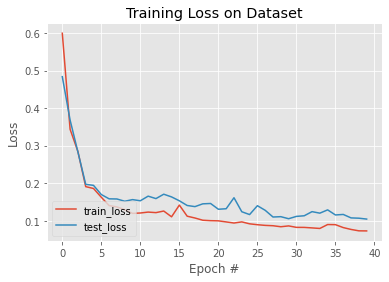

In [ ]:
train(lossFunc = BCEWithLogitsLoss(), opt = Adam, batchSize = 7, epochs = 40, showPlot = True)

# R: Predict from trained model

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import cv2
import os
import secrets

def prepare_plot(origImage, origMask, predMask):
  # initialize our figure
  figure, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))
  # plot the original image, its mask, and the predicted mask
  ax[0].imshow(origImage)
  ax[1].imshow(origMask)
  ax[2].imshow(predMask)
  # set the titles of the subplots
  ax[0].set_title("Image")
  ax[1].set_title("Original Mask")
  ax[2].set_title("Predicted Mask")
  # set the layout of the figure and display it
  figure.tight_layout()
  figure.show()

def predict(threshold, idx = None, showComparison = True):
  imagePaths = [f for f in os.listdir(IMAGE_DATASET_PATH) if os.path.isfile(os.path.join(IMAGE_DATASET_PATH, f))]
  imagePaths.sort()
  # select random image
  if idx == None:
    imagePath = secrets.choice(imagePaths)
  else:
    imagePath = imagePaths[idx]
  imagePath = os.path.join(IMAGE_DATASET_PATH, imagePath)
  # load and set model to evaluation mode
  model = torch.load(MODEL_PATH).to(DEVICE)
  model.eval()
  # turn off gradient tracking
  with torch.no_grad():
    # load the image from disk, swap its color channels, cast it
    # to float data type, and scale its pixel values
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image.astype("float32") / 255.0
    # resize the image and make a copy of it for visualization
    image = cv2.resize(image, (128, 128))
    orig = image.copy()
    # find the filename and generate the path to ground truth mask
    filename = imagePath.split(os.path.sep)[-1]
    groundTruthPath = os.path.join(MASK_DATASET_PATH, filename)
    # load the ground-truth segmentation mask in grayscale mode
    # and resize it
    gtMask = cv2.imread(groundTruthPath, 0)
    gtMask = cv2.resize(gtMask, (INPUT_IMAGE_HEIGHT, INPUT_IMAGE_HEIGHT))

    # make the channel axis to be the leading one, add a batch
    # dimension, create a PyTorch tensor, and flash it to the
    # current device
    image = np.transpose(image, (2, 0, 1))
    image = np.expand_dims(image, 0)
    image = torch.from_numpy(image).to(DEVICE)
    # make the prediction, pass the results through the sigmoid
    # function, and convert the result to a NumPy array
    predMask = model(image).squeeze()
    predMask = torch.sigmoid(predMask)
    predMask = predMask.cpu().numpy()
    # filter out the weak predictions and convert them to integers
    predMask = (predMask > threshold) * 255
    predMask = predMask.astype(np.uint8)
    if showComparison:
      # prepare a plot for visualization
      prepare_plot(orig, gtMask, predMask)
    return predMask

# Testing predictor

input
['T001O_crop_0.png', 'T001O_crop_1.png', 'T002O_crop_2.png', 'T002O_crop_3.png', 'T002O_crop_4.png', 'T003O_crop_1.png', 'T003O_crop_2.png', 'T003O_crop_3.png', 'T003O_crop_4.png', 'T004O_crop_1.png', 'T005O_crop_0.png', 'T005O_crop_1.png', 'T005O_crop_2.png', 'T006O_crop_1.png', 'T007O_crop_0.png', 'T008O_crop_0.png', 'T008O_crop_1.png', 'T008O_crop_2.png', 'T009O_crop_1.png', 'T009O_crop_2.png', 'T009O_crop_3.png', 'T010O_crop_1.png', 'T010O_crop_2.png', 'T011O_crop_0.png', 'T011O_crop_1.png', 'T011O_crop_2.png', 'T012O_crop_2.png', 'T012O_crop_3.png', 'T013O_crop_1.png', 'T013O_crop_2.png', 'T014O_crop_0.png', 'T014O_crop_2.png', 'T014O_crop_3.png', 'T015O_crop_1.png', 'T016O_crop_1.png', 'T016O_crop_3.png', 'T017O_crop_2.png', 'T018O_crop_0.png', 'T019O_crop_1.png', 'T019O_crop_3.png', 'T020O_crop_1.png', 'T020O_crop_2.png', 'T021O_crop_0.png', 'T021O_crop_3.png', 'T022O_crop_2.png', 'T023O_crop_0.png', 'T023O_crop_1.png', 'T024O_crop_1.png', 'T024O_crop_2.png', 'T025O_crop_0

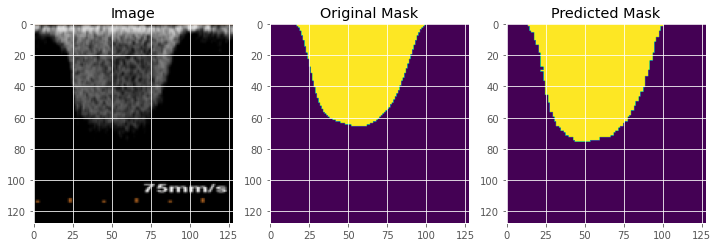

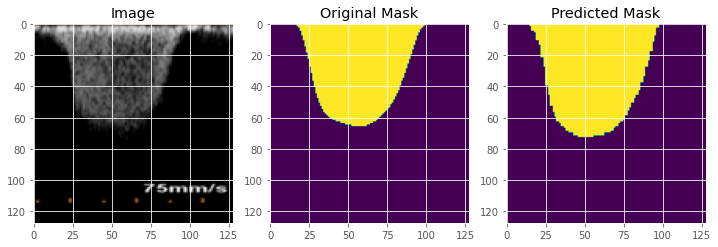

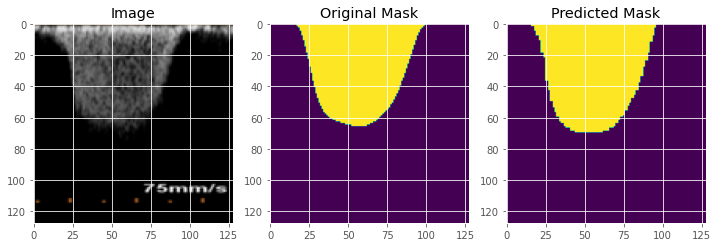

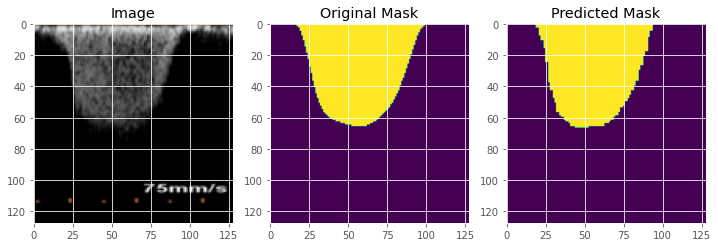

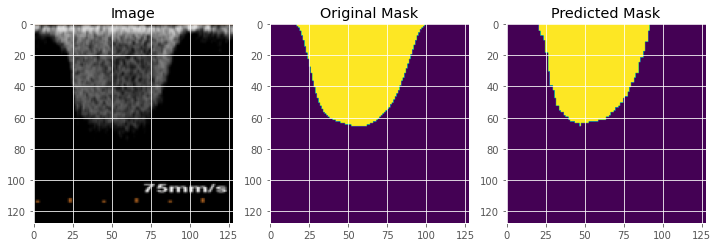

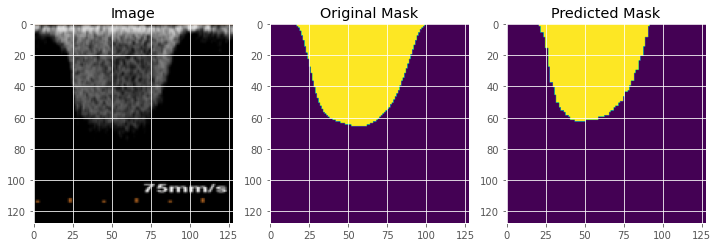

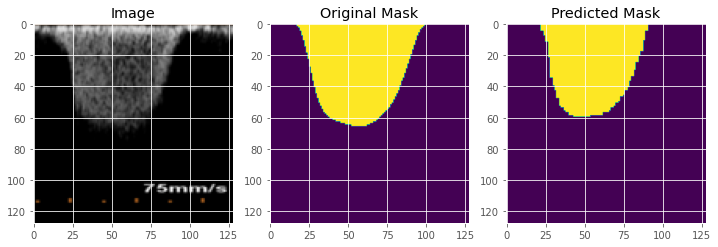

In [ ]:
print(IMAGE_DATASET_PATH)
files = [f for f in os.listdir(IMAGE_DATASET_PATH) if os.path.isfile(os.path.join(IMAGE_DATASET_PATH, f))]
files.sort()
print(files)
print(files.index("T075O_crop_0.png")) # 145
print(files.index("T073O_crop_0.png")) # 141
print(files.index("T041O_crop_3.png")) # 85
print(files.index("T033O_crop_1.png")) # 66
print(files.index("T016O_crop_3.png")) # 35

predict(threshold = 0.1, idx = 35)
predict(threshold = 0.2, idx = 35)
predict(threshold = 0.3, idx = 35)
predict(threshold = 0.5, idx = 35)
predict(threshold = 0.7, idx = 35)
predict(threshold = 0.8, idx = 35)
predict(threshold = 0.9, idx = 35)

# R: Train and predict

In [14]:
def train_and_predict(lossFunc = BCEWithLogitsLoss(), opt = Adam, batchSize = 40, epochs = 40, showInfo = False, showPlot = False):
  train(lossFunc, opt, batchSize, epochs, showInfo, showPlot)
  predict(threshold = 0.7, idx = 35)
  predict(threshold = 0.7, idx = 66)
  predict(threshold = 0.7, idx = 85)
  predict(threshold = 0.7, idx = 141)
  predict(threshold = 0.7, idx = 145)

# Try different losses, optimizers and batch sizes
## Batching
153 samples, batch size 31
we get 29 in the last batch, good (153 mod 14 = 13).

At least, that was the initial idea, but considering we don't have that many samples, a batch size of 7 was chosen. Last batch size will be 6 (153 mod 7 = 6).

see https://stats.stackexchange.com/questions/153531/what-is-batch-size-in-neural-network
  

100%|██████████| 40/40 [00:51<00:00,  1.29s/it]


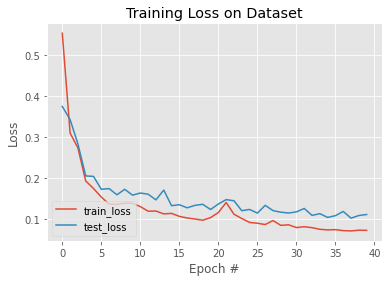

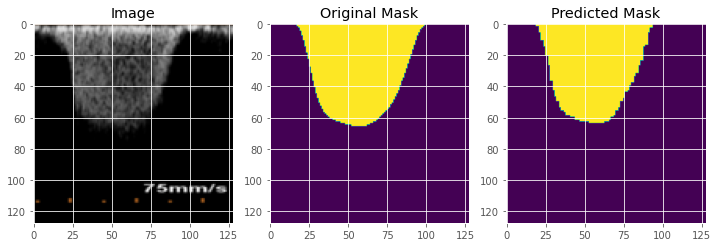

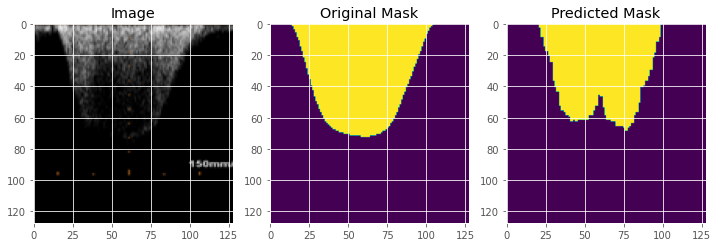

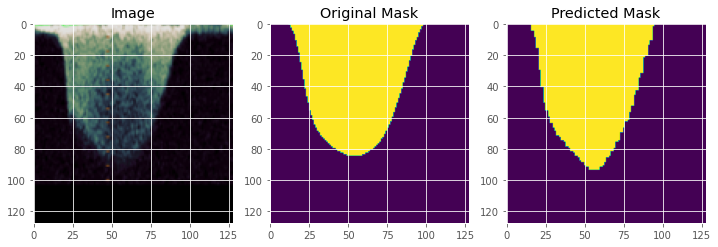

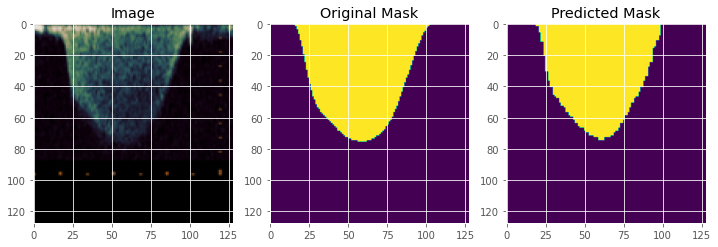

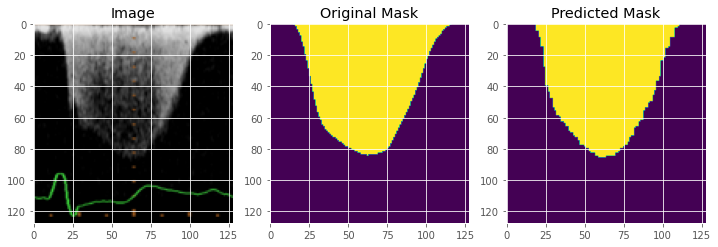

In [ ]:
train_and_predict(lossFunc = BCEWithLogitsLoss(), opt = Adam, batchSize = 7, epochs = 40, showPlot = True)

100%|██████████| 40/40 [00:43<00:00,  1.08s/it]


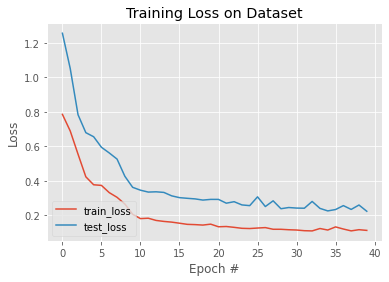

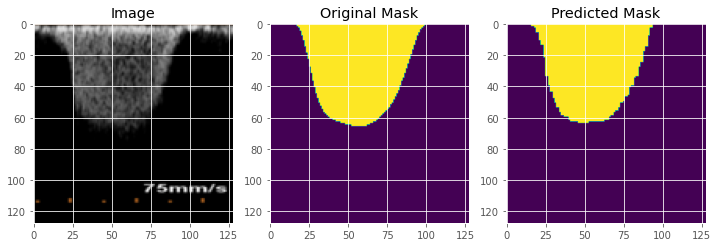

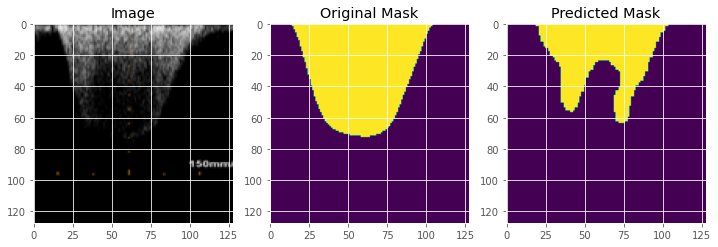

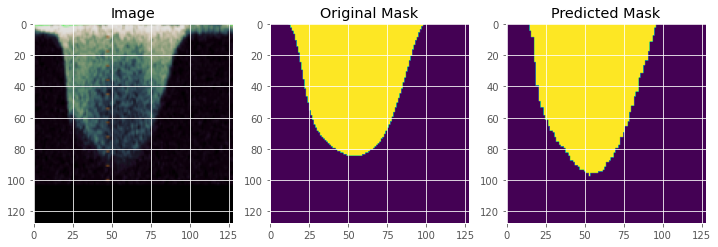

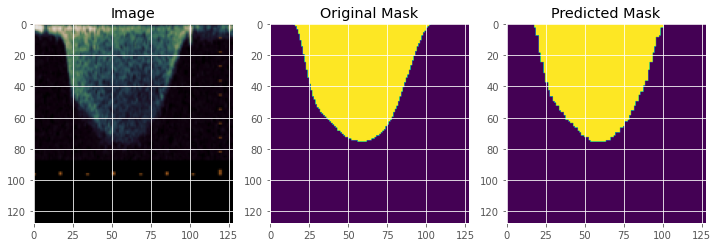

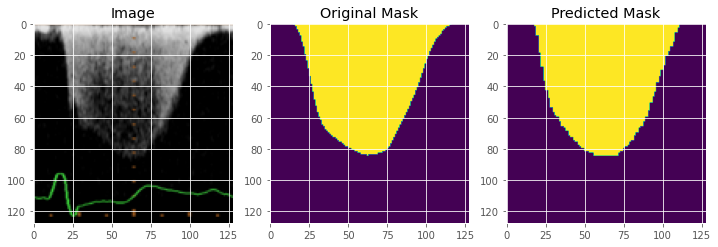

In [ ]:
train_and_predict(lossFunc = BCEWithLogitsLoss(), opt = Adam, batchSize = 22, epochs = 40, showPlot = True)

100%|██████████| 80/80 [01:27<00:00,  1.09s/it]


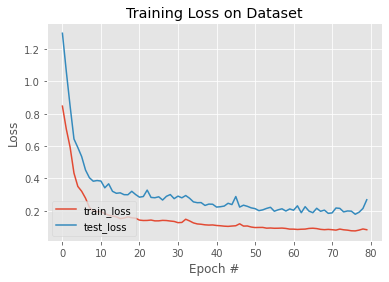

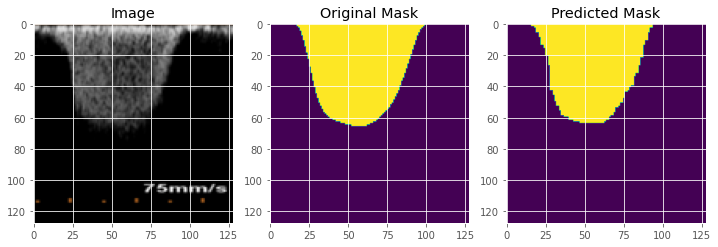

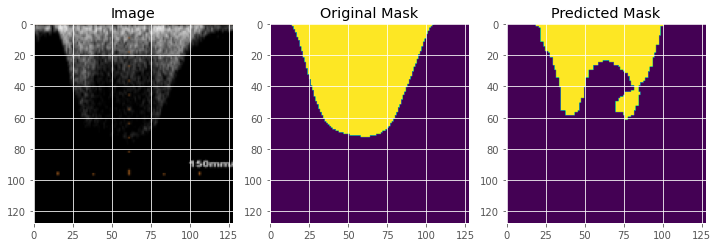

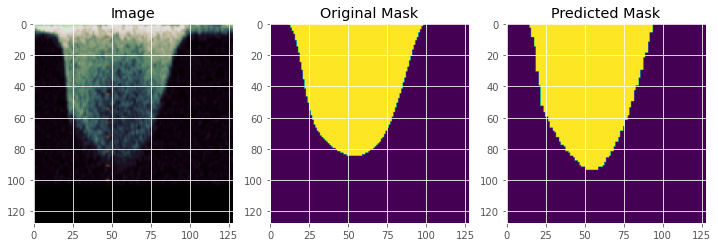

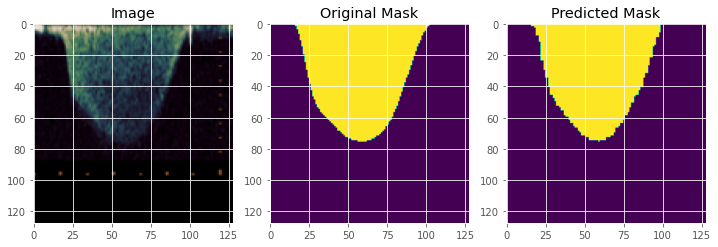

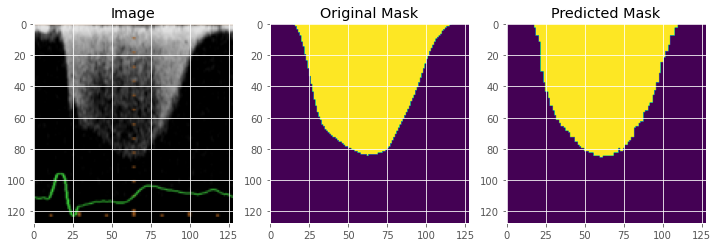

In [ ]:
train_and_predict(lossFunc = BCEWithLogitsLoss(), opt = Adam, batchSize = 22, epochs = 80, showPlot = True)

100%|██████████| 80/80 [01:14<00:00,  1.07it/s]


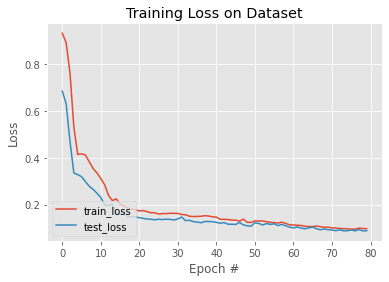

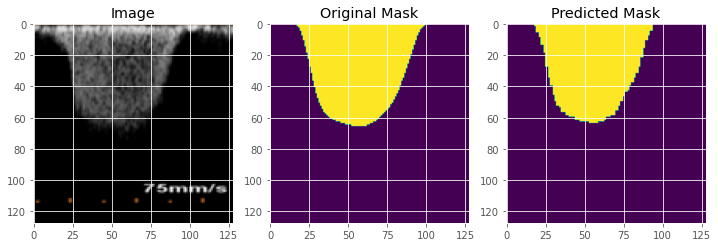

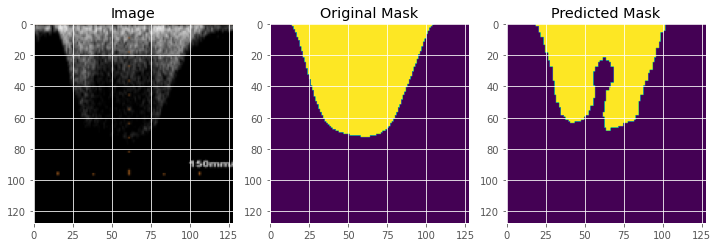

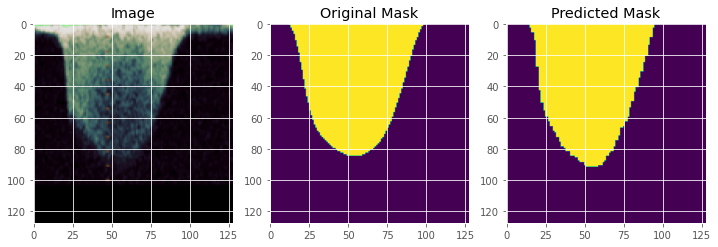

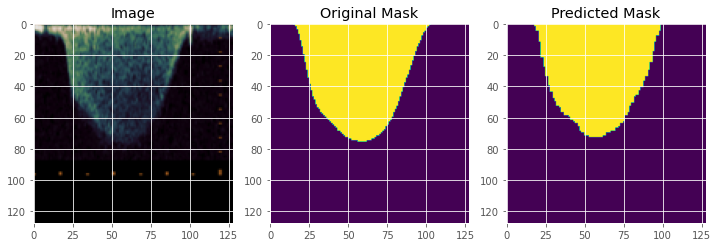

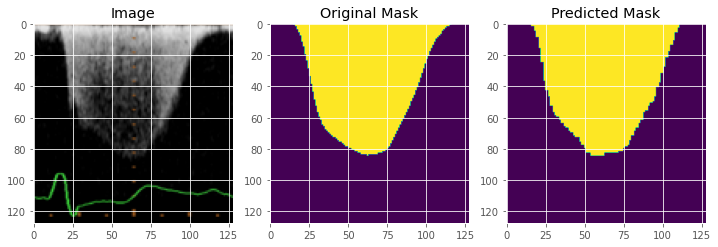

In [ ]:
train_and_predict(lossFunc = BCEWithLogitsLoss(), opt = Adam, batchSize = 31, epochs = 80, showPlot = True)

100%|██████████| 100/100 [01:41<00:00,  1.01s/it]


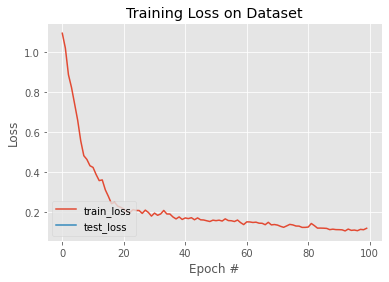

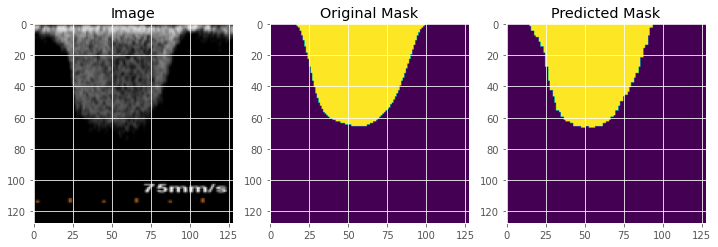

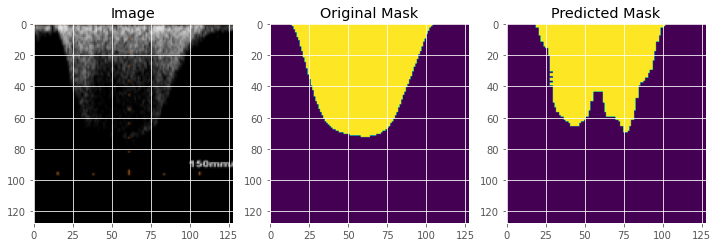

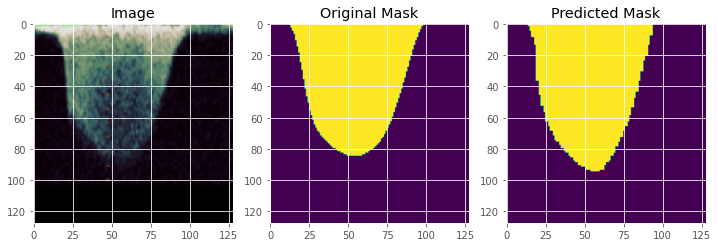

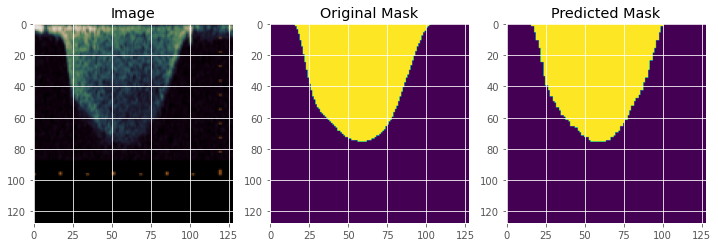

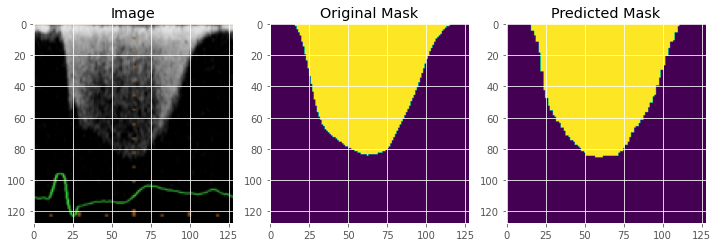

In [ ]:
train_and_predict(lossFunc = BCEWithLogitsLoss(), opt = Adam, batchSize = 52, epochs = 100, showPlot = True)

100%|██████████| 40/40 [00:37<00:00,  1.05it/s]


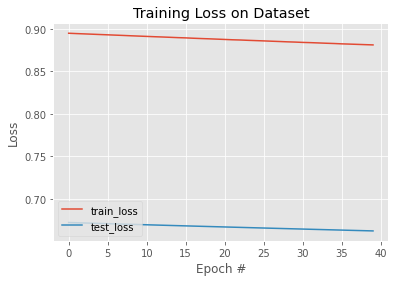

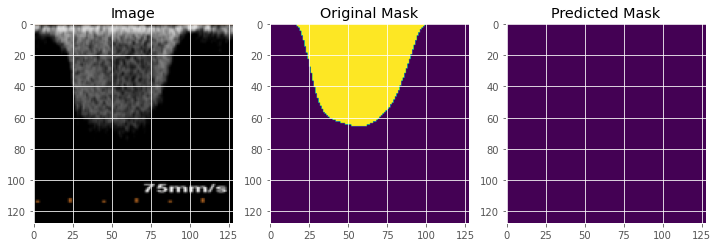

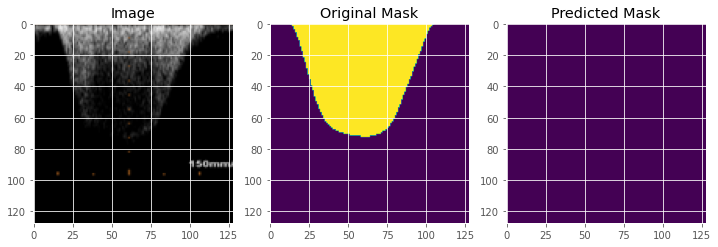

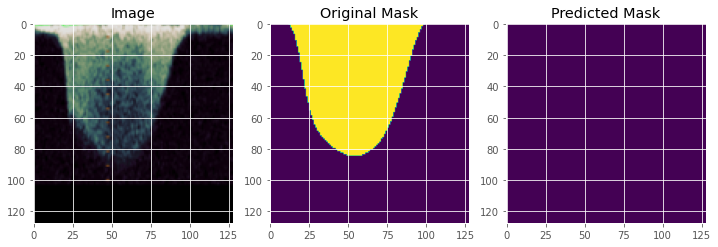

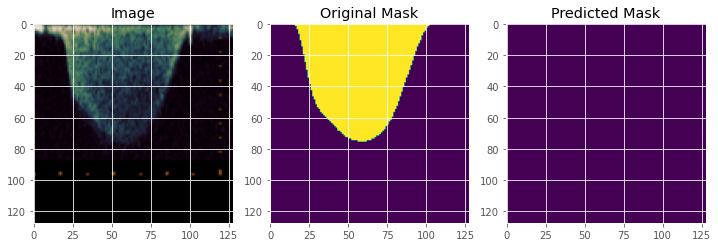

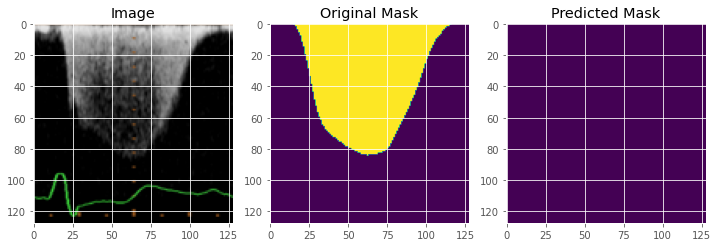

In [ ]:
train_and_predict(lossFunc = BCEWithLogitsLoss(), opt = SGD, batchSize = 31, epochs = 40, showPlot = True)

100%|██████████| 40/40 [00:45<00:00,  1.13s/it]


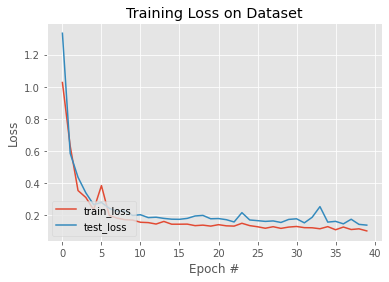

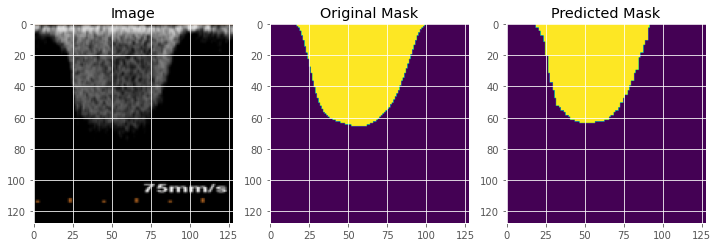

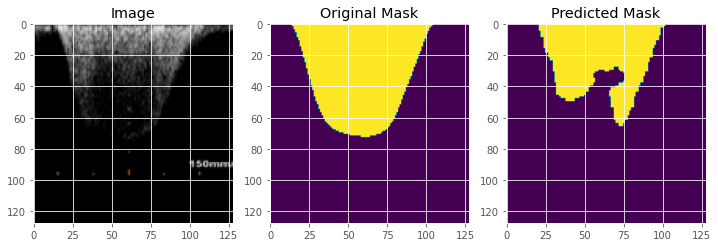

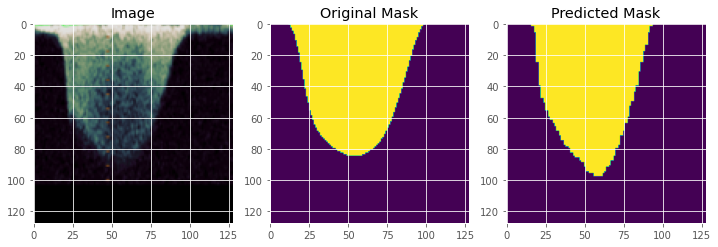

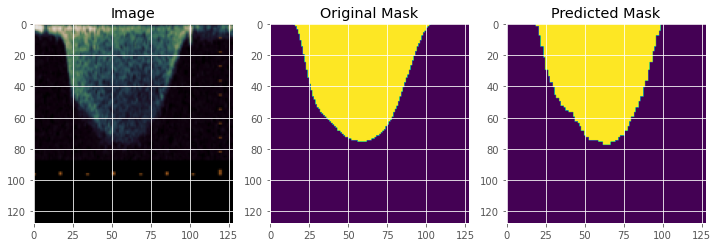

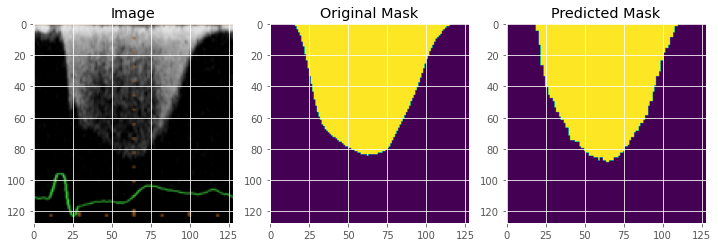

In [ ]:
train_and_predict(lossFunc = BCEWithLogitsLoss(), opt = RMSprop, batchSize = 14, epochs = 40, showPlot = True)

100%|██████████| 80/80 [01:16<00:00,  1.04it/s]


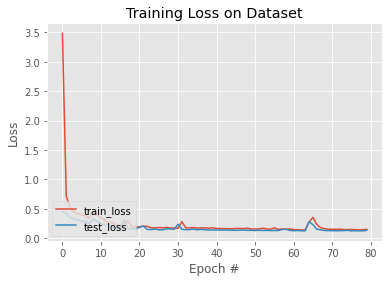

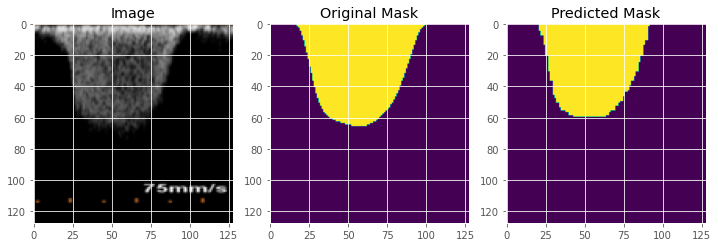

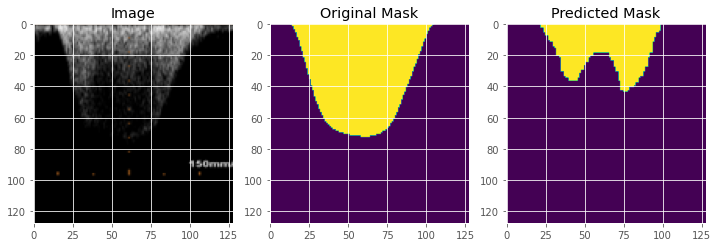

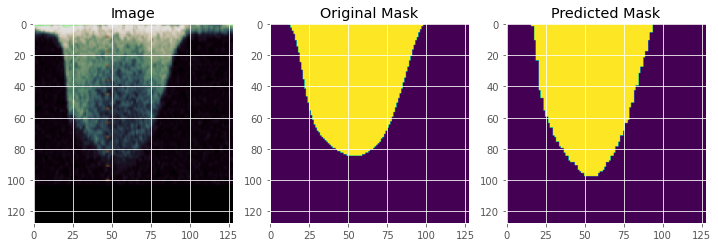

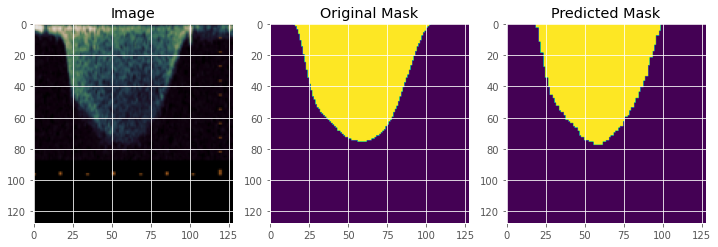

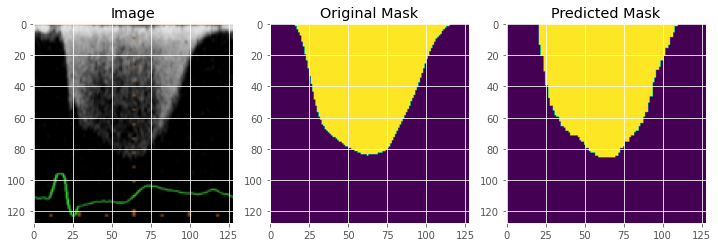

In [ ]:
train_and_predict(lossFunc = BCEWithLogitsLoss(), opt = RMSprop, batchSize = 31, epochs = 80, showPlot = True)

100%|██████████| 40/40 [00:41<00:00,  1.03s/it]


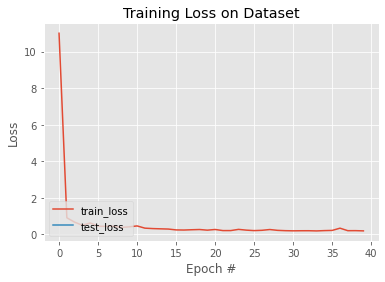

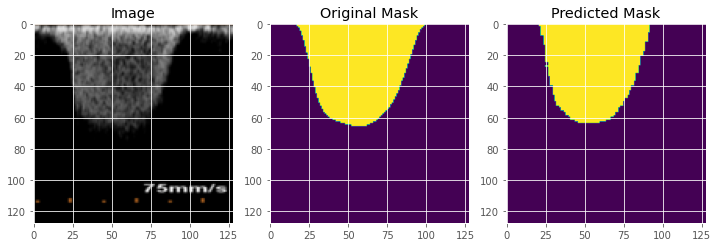

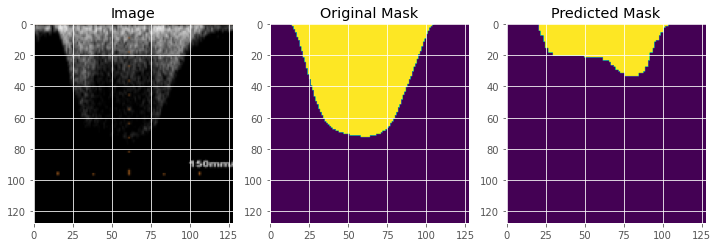

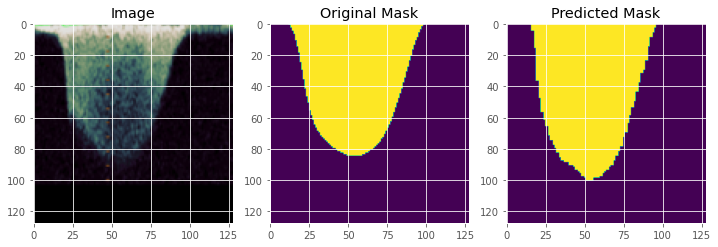

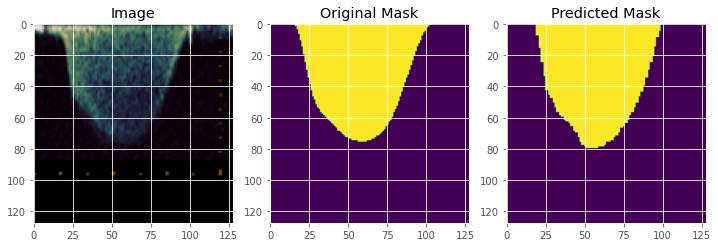

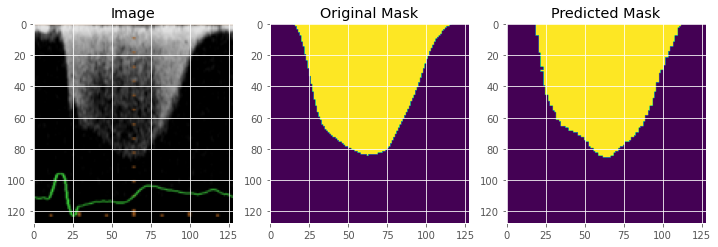

In [ ]:
train_and_predict(lossFunc = BCEWithLogitsLoss(), opt = RMSprop, batchSize = 52, epochs = 40, showPlot = True)

100%|██████████| 80/80 [01:23<00:00,  1.04s/it]


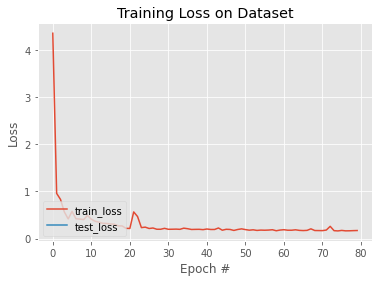

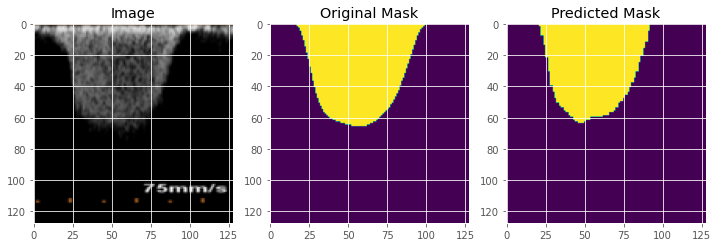

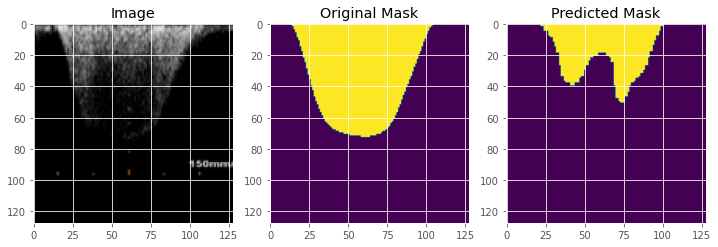

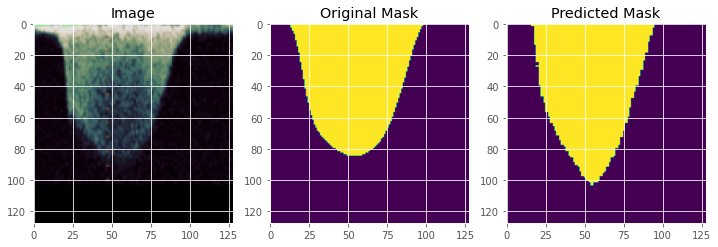

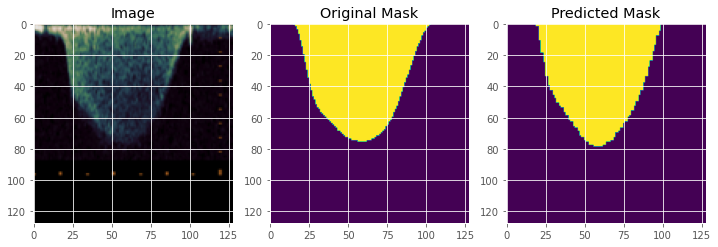

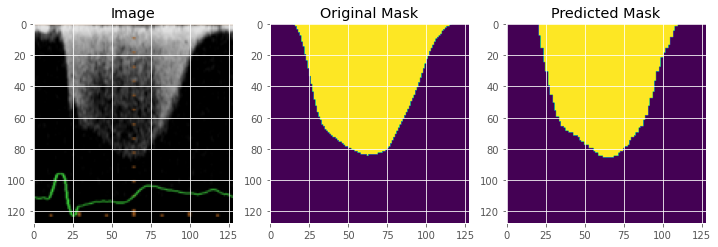

In [ ]:
train_and_predict(lossFunc = BCEWithLogitsLoss(), opt = RMSprop, batchSize = 52, epochs = 80, showPlot = True)

# R: Training for the best outcome

100%|██████████| 100/100 [01:37<00:00,  1.02it/s]


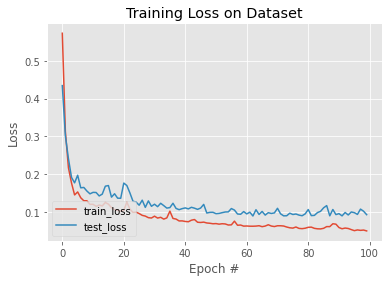

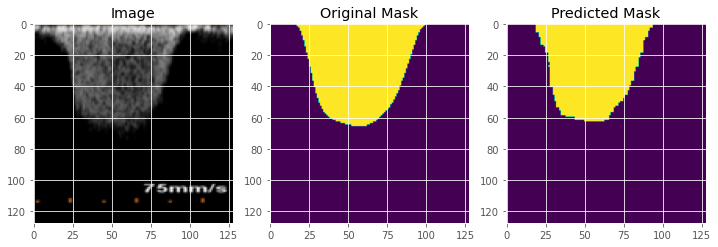

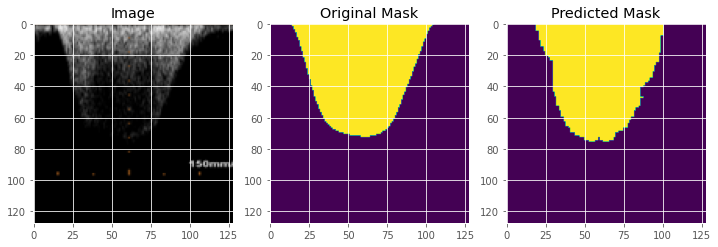

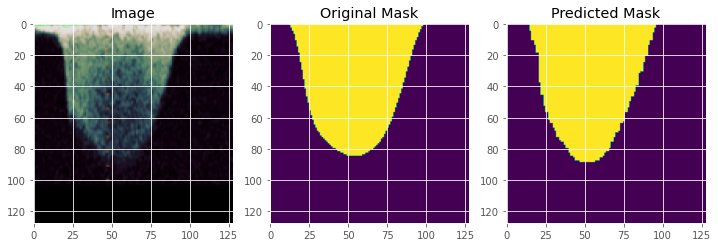

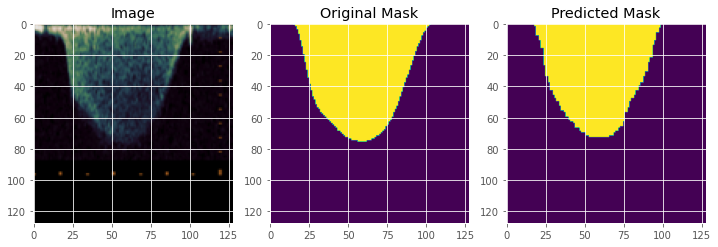

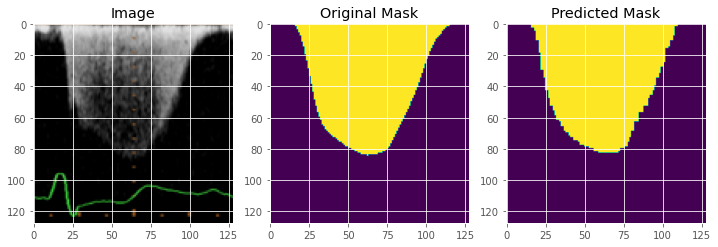

In [15]:
train_and_predict(lossFunc = BCEWithLogitsLoss(), opt = Adam, batchSize = 7, epochs = 100, showPlot = True)

# Find vmax
We read the pixel data from the predicted mask image with numpy.
The Vmax is found by finding the first row along the y-axis where all pixel values are 0 (representing black).

y: 95, vmax: 4.82421875


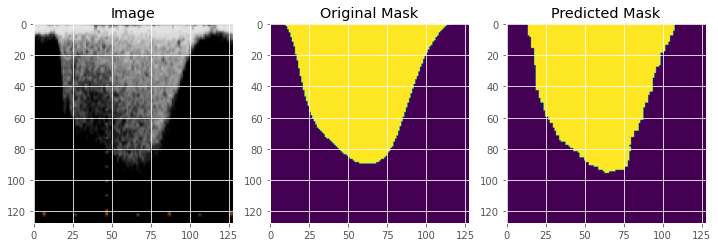

In [24]:
from math import nan
prediction = predict(threshold = 0.7)

# Find first row in y-axis in image where all values in that row are 0
def findYvmax(prediction):
  for i in range(len(prediction)):
    if np.sum(prediction[i]) == 0:
      return i-1
y = findYvmax(prediction)

# in y row, find first and last x where value is 1, and take the middle x
# def findXvmax(prediction, y):
#   x1 = -1
#   x2 = -1
#   for x in range(len(prediction[y])):
#     if prediction[y][x] == 255:
#       x1 = x
#       break
#   for x in range(len(prediction[y])-1, 0, -1):
#     if prediction[y][x] == 255:
#       x2 = x
#       break
#   if x1 != -1 and x2 != -1:
#     return x1 + ((x2 - x1) / 2)
#   else:
#     return nan
# x = findXvmax(prediction, y)

# NOTE: could not accurately get the max velocity from the journal
# https://www.ahajournals.org/doi/abs/10.1161/circ.144.suppl_1.10657#d9189987e95
maxv = 6.5

# velocity max m/s
vmax = y / len(prediction) * maxv

print(f"y: {y}, vmax: {vmax}")

# ETC

In [ ]:
import shutil

shutil.rmtree("input")
shutil.rmtree("target")